In [74]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.integrate import quad, solve_ivp, odeint
from scipy.optimize import root_scalar, newton, toms748
from scipy.interpolate import splprep, splev
from numpy import pi, sqrt, exp, arcsinh, log as ln

plt.rcParams['mathtext.fontset'] = 'cm'
font = {'family' : 'serif', 
        'size': 20}
plt.rc('font', **font)
plt.rc('lines', lw=2)

In [75]:
c = 2.998e8
G = 6.67e-11
hbar = 1.055e-34

m = 1.67e-27

M0 = 1.98841 * 10**30

u0 = m**4 / (8 * pi**2) * (c**5 / hbar**3) 
m0 = c**4 / sqrt(4*pi/3 * u0 * G**3) / M0
r0 = G * m0*M0 / c**2 / 1e3 # (km)


print(u0)
print(m0)
print(r0)

2.0317810988307798e+35
8.084423614780565
11.92937188593875


In [76]:
x = sp.Symbol("x")

u_symb = (2*x**3 + x) * sp.sqrt(1 + x**2) - sp.asinh(x) 
p_symb = 1 / 3 * ((2*x**3 - 3*x) * sp.sqrt(1 + x**2) + 3*sp.asinh(x))

ux = sp.lambdify(x, u_symb, "numpy")
px = sp.lambdify(x, p_symb, "numpy")

fprime = sp.lambdify(x, p_symb.diff(x).simplify())

In [77]:
def u(p0, x0=1) -> float:
    if p0<0: return 0
    f = lambda x: px(x) - p0

    # bracket: x in (0, 1e4) corresponds to u in (0, 2e16)
    x = root_scalar(f, x0=x0, bracket=(0, 1e4)).root
    u0 = ux(x)
    return u0

uv = np.vectorize(u)

In [78]:
x = 10**np.linspace(-8, 3, 100)
%timeit uv(x)

14.9 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


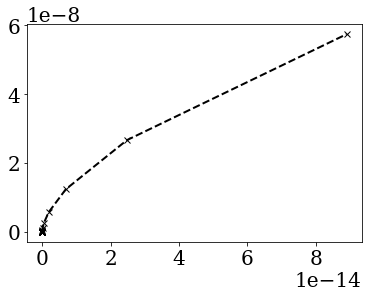

In [79]:
plt.plot(
    px(x[:50]), 
    uv(px(x[:50])),
    "k--x"
)

In [80]:
def dmdr(r, y, args):
    p, m = y
    return 3 * u(p) * r**2

def dpdr(r, y, args):
    p, m = y
    if r<1e-10:
        p0 = args
        u0 = u(p0)
        return - r * (p + u(p)) * (3 * p + u0) / (1 - 2*u0*r**2)
    else:
        Dp = - 1 / r**2 * (p + u(p)) * (3 * p * r**3 + m) /  (1 - 2 * m/r)
        return Dp

In [81]:
def f(r, y, args):
    return dpdr(r, y, args), dmdr(r, y, args)

def stop(r, y, args):
    p, m = y
    return p
stop.terminal = True


In [82]:
def sim(p0 = 0.82):
    return solve_ivp( 
        f, (0, 1e4), (p0, 0), args=(p0,), events=stop, dense_output=True, max_step=0.01
        )

In [83]:
s = sim(0.82)

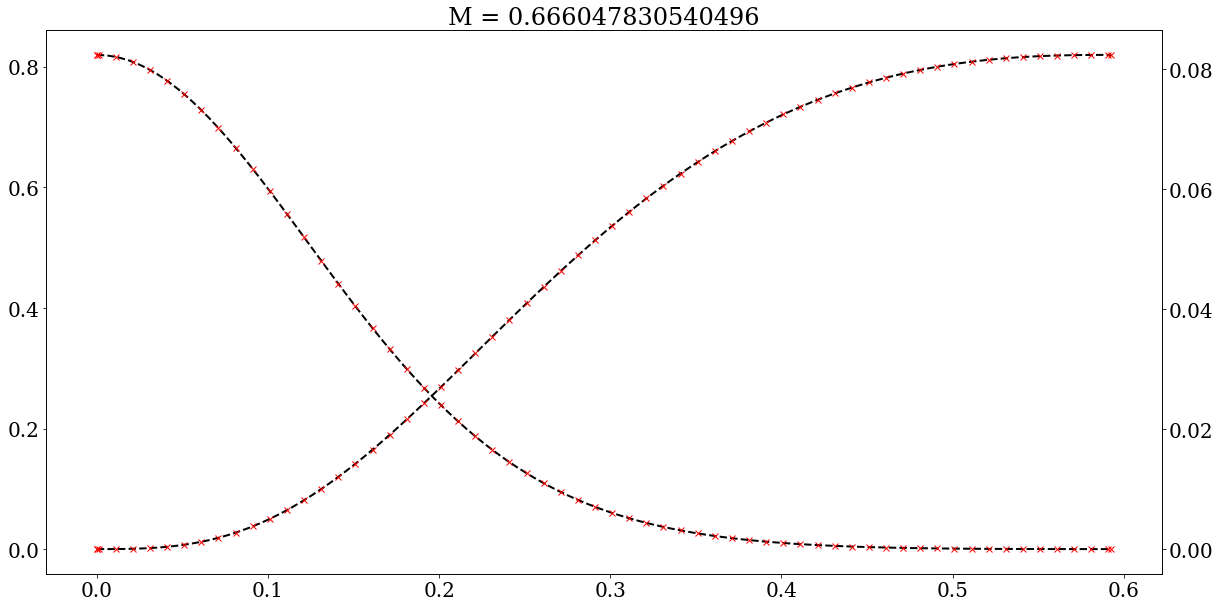

In [84]:
r = s.t
p = s.y[0]
M = s.y[1]


r1 = np.linspace(r[0], r[-1], 100)

fig, ax = plt.subplots(figsize=(20, 10))
n = 0
m = -1

ax.plot(r1, s.sol(r1)[0], "--k")
ax.plot(r, p, "xr")

ax2 = ax.twinx()
ax2.plot(r1, s.sol(r1)[1], "--k")
ax2.plot(r, M, "xr")

ax.set_title("M = {}".format(M[-1]*m0))

plt.show()


In [85]:
def sim_many():
    N = 100
    p0s = 10**np.linspace(-5, 3, N)

    M = np.zeros(N)
    R = np.zeros(N)
    ps = []
    rs = []
    ms = []

    for i, p0 in enumerate(p0s):
        s1 = solve_ivp(f, (0, 1e3), (p0, 0), args=(p0,), events=stop, max_step=0.001)
        p, m = s1.y
        r = s1.t

        rs.append(r)
        ps.append(p)
        ms.append(m)

        M[i] = m[-1] #* m0
        R[i] = r[-1] #* r0

    return R, M, rs, ps, ms


In [86]:
R, M, r, p, m = sim_many()

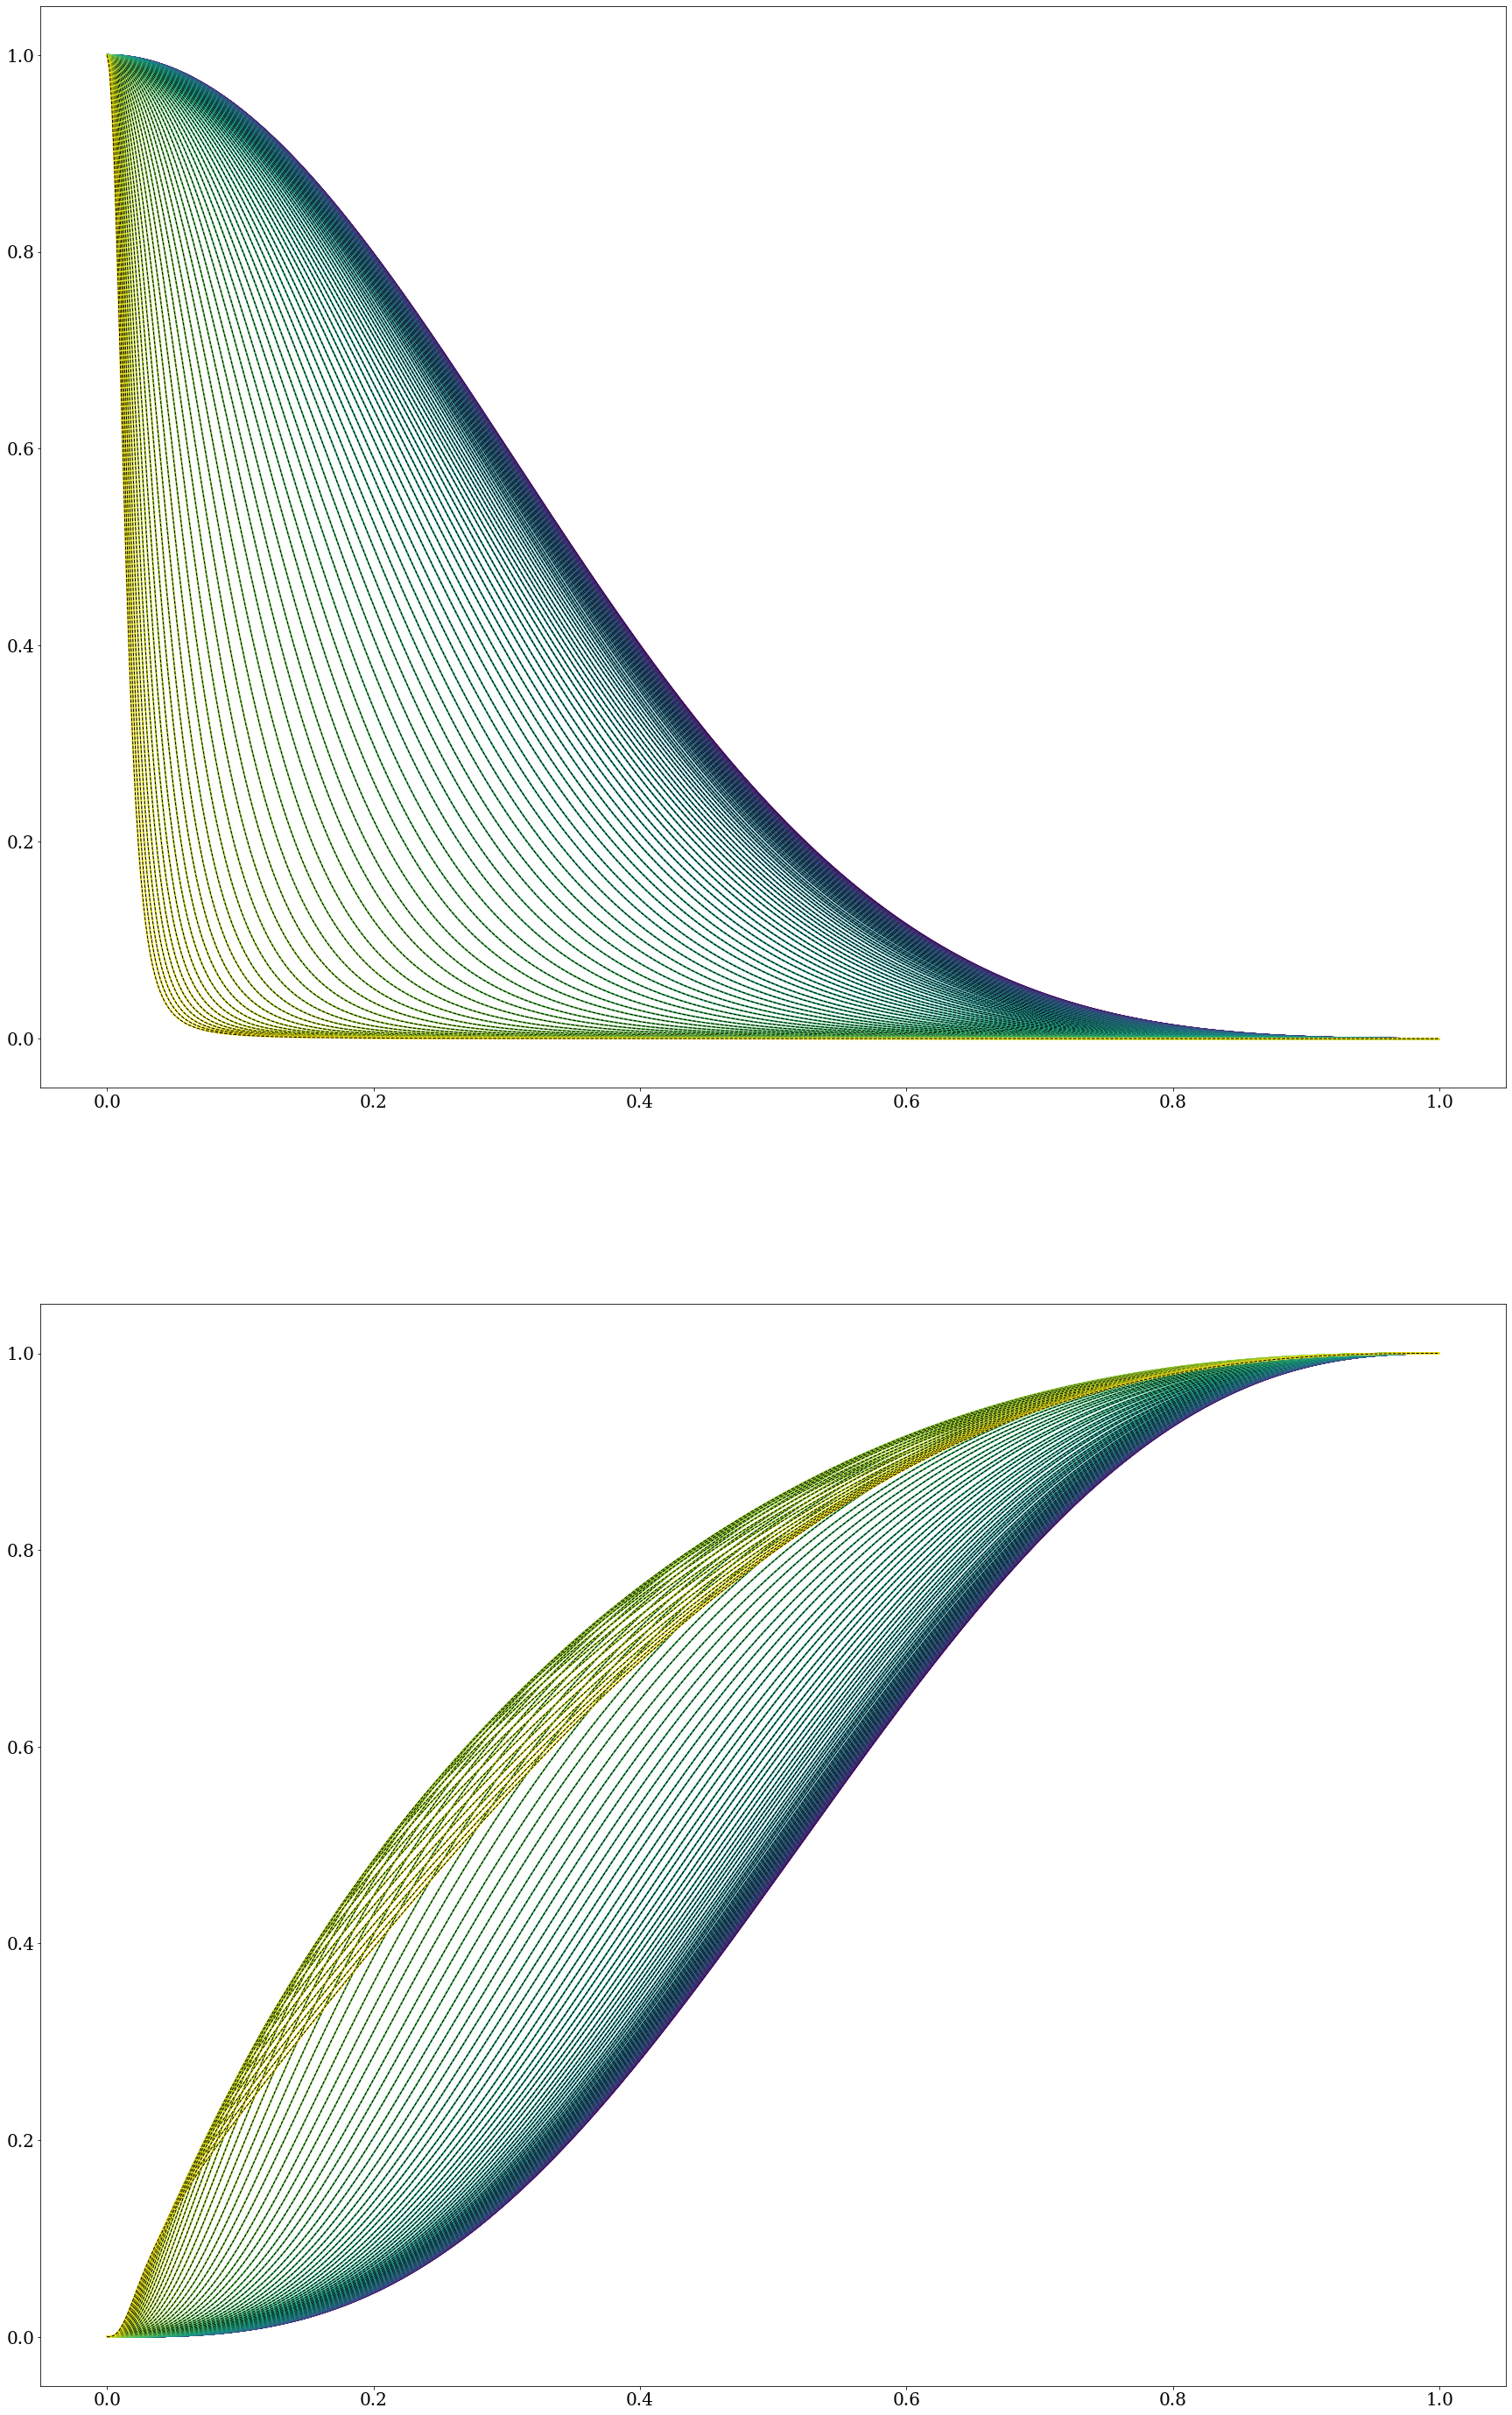

In [87]:
fig, ax = plt.subplots(2, figsize=(30, 50))
for i in range(len(r)):
    if i % 1 == 0:
        ax[0].plot(r[i]/r[i][-1], p[i]/p[i][0], color=cm.viridis(i/len(r)))
        ax[0].plot(r[i]/r[i][-1], p[i]/p[i][0], "--k", lw=1)
        ax[1].plot(r[i]/r[i][-1], m[i]/m[i][-1], lw=2,  color=cm.viridis(i/len(r)))
        ax[1].plot(r[i]/r[i][-1], m[i]/m[i][-1], "--k", lw=1)
plt.show()

0.7153756347128412
9.094107589580062


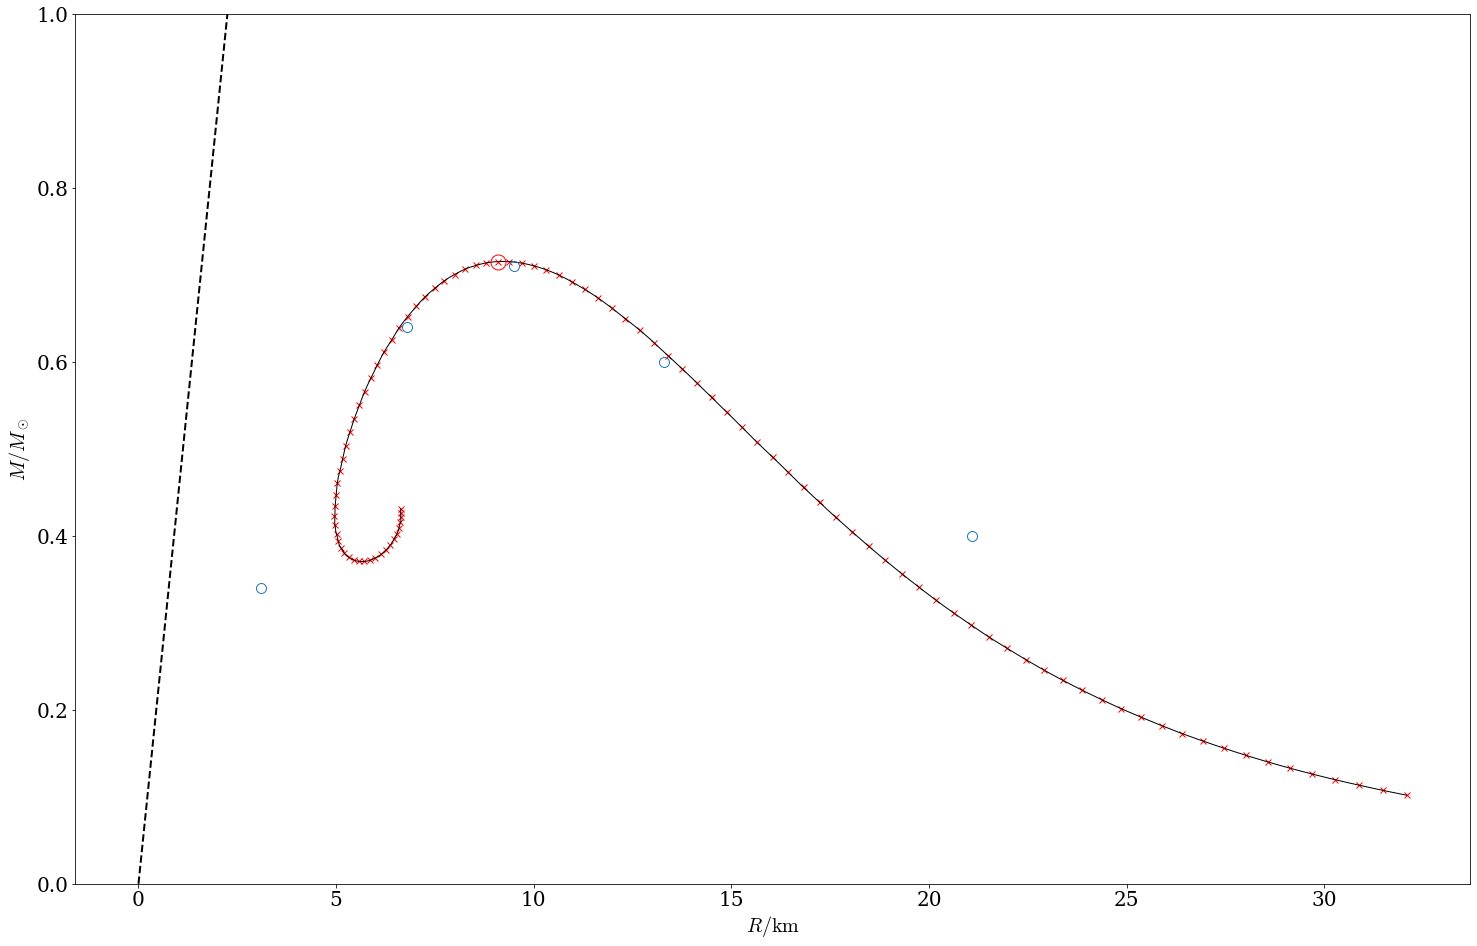

In [98]:
Rs = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots(figsize=(25, 16))

ax.plot(Rs, 4 / 9 * Rs, "k--")
ax.plot(R*r0, M*m0, "rx")

n = 1
P = [(R*r0)[::n], (M*m0)[::n]]

tck, _ = splprep(P, s=0)
c = lambda t: splev(t, tck)

t = np.linspace(0, 1, 1000)
ax.plot(*c(t), "k", lw=1)

ax.set_ylim(0, 1)

ax.set_xlabel(r"$R / \mathrm{km}$")
ax.set_ylabel(r"$M /  M_\odot$")

i = np.argmax(M)
print(M[i]*m0)
print(R[i]*r0)
ax.plot(R[i]*r0, M[i]*m0, "ro", ms=15, fillstyle="none")

R_oppenheimer = [21.1, 13.3, 9.5, 6.8, 3.1]
M_oppenheimer = [0.4, 0.6, 0.71, 0.64, 0.34]

ax.plot(R_oppenheimer, M_oppenheimer, "o", ms=10, fillstyle="none")


plt.show()